# 1. Semisupervised Model
Author: _Carlos Sevilla Salcedo (Updated: 18/07/2019)_

In this notebook we are going to present the modification included to the method to work with semisupervised data. The main inclusion in the semisupervised model is that we are going to consider some data of the views as random variables to include in the joint probability distribution and, therefore, in the _q_ distribution. These new variables $X^{(1)*}$ and $X^{(2)*}$ will have the size of the unknown data and will need to be inferred. Equivalently, variable $Z$ will also need to be modified for the samples that need to be determined. 

To work computationally efficiently, we can redefine matrices $X^{(1)}$ and $X^{(2)}$ so that the rest of the equations we have previously calculated don't need to be changed:
<img src="Images/X_SS.png" style="max-width:100%; width: 40%">

This new definition of the model does not only allow us to predict the unknown data of the desired view but also allows us to automatically infer any missing data in any of the views. At the same time this formulation works the different extensions of the model presented in the next notebooks.

## Synthetic data generation

We can now generate data in a similar manner to the regression model to compare the performance of both apporaches.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
np.random.seed(0)

N = 1000  # number of samples
D0 = 55  # input features
D1 = 3   # output features

myKc = 20

K = 2       # common latent variables
K0 = 3      # first view's latent variables
K1 = 3      # second view's latent variables
Kc=K+K0+K1  # latent variables

# Generation of matrix W
A0 = np.random.normal(0.0, 1, D0 * K).reshape(D0, K)
A1 = np.random.normal(0.0, 1, D1 * K).reshape(D1, K)

B0 = np.random.normal(0.0, 1, D0 * K0).reshape(D0, K0)
B1 = np.random.normal(0.0, 1, D1 * K1).reshape(D1, K1)

W0 = np.hstack((np.hstack((A0,B0)),np.zeros((D0,K1))))
W1 = np.hstack((np.hstack((A1,np.zeros((D1,K0)))),B1))
W_tot = np.vstack((W0,W1))

# Generation of matrix Z
Z = np.random.normal(0.0, 1, Kc * N).reshape(N, Kc)

# Generation of matrix X
X0 = np.dot(Z,W0.T) + np.random.normal(0.0, 0.1, D0 * N).reshape(N, D0)
X1 = np.dot(Z,W1.T) + np.random.normal(0.0, 0.1, D1 * N).reshape(N, D1)

Once the data is generated we divide it into train and test in order to be able to test the performance of the model. After that, we can normalize the data.

In [2]:
from sklearn.model_selection import train_test_split
X_tr, X_tst, Y_tr, Y_tst = train_test_split(X0, X1, test_size=0.3, random_state = 31)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_tst = scaler.transform(X_tst)

## Training the model

Once the data is prepared we just have to feed it to the model. As the model has so many possibilities we have decided to pass the data to the model following a particular structure so that we can now, for each view, if the data corresponds to real, multilabel or categorical as well as knowing if we want to calculate the model with sparsity in the features.

In this case we are indicating we want to prune the latent features, so that if a latent feature has a sufficiently low value for all the features in matrix $W$, this latent feature will be eliminated.

In [3]:
import os
os.sys.path.append('lib')
import sshiba

In [4]:
myKc = 20            # number of latent features
max_it = int(5*1e4)  # maximum number of iterations
tol = 1e-6           # tolerance of the stopping condition (abs(1 - L[-2]/L[-1]) < tol)
prune = 1            # whether to prune the irrelevant latent features

X = np.vstack((X_tr,X_tst))

myModel = sshiba.SSHIBA(myKc, prune)
X0 = myModel.struct_data(X, 0, 0)
X1_tr = myModel.struct_data(Y_tr, 0, 0)
X1_tst = myModel.struct_data(Y_tst, 0, 0)
myModel.fit(X0, X1_tr, max_iter = max_it, tol = tol, Y_tst = X1_tst, mse = 1)
print('Final MSE %.3f' %(myModel.mse[-1]))

Iteration 2929 Lower Bound 224699.7 K   20
Model correctly trained. Convergence achieved
Final L(Q):    224699.7
Final MSE 9.669


## Visualization of the results

### Lower Bound and MSE
Now the model is trained we can plot the evolution of the lower bound through out the iterations. This lower bound is calculated using the values of the variables the model is calculating and is the value we are maximizing. As we want to maximize this value it has to be always increasing with each iteration.

At the same time, we are plotting now the evolution of the Minimum Square Error (MSE) with each update of the model. As we are not minimizing this curve, this doesn't necessarily have to be always decreasing and might need more iterations to reach a minimum. 

In [5]:
def plot_mse(mse):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(mse, linewidth=2, marker='s',markersize=5, label='SSHIBA', markerfacecolor='red')
    ax.grid()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('MSE')
    plt.legend()

def plot_L(L):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(L, linewidth=2, marker='s',markersize=5, markerfacecolor='red')
    ax.grid()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('L(Q)')

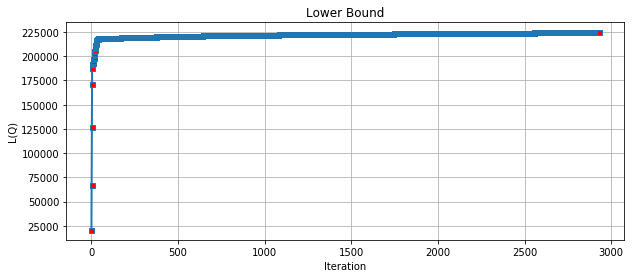

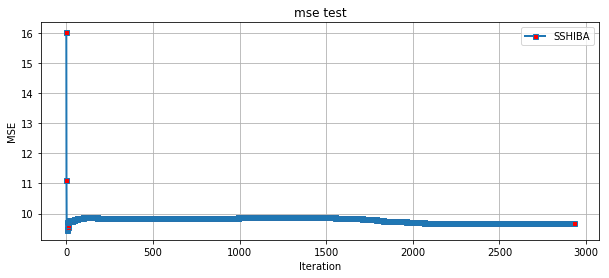

In [6]:
plot_L(myModel.L)
plt.title('Lower Bound')

plot_mse(myModel.mse)
plt.title('mse test')
plt.show()

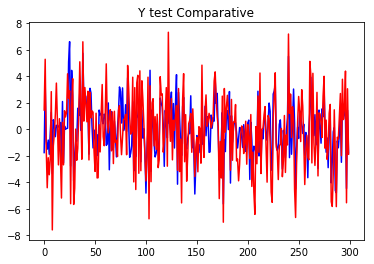

In [7]:
q = myModel.q_dist
Y_pred_tst = myModel.X[1]['mean'][Y_tr.shape[0]:,:]
plt.figure()
plt.plot(Y_pred_tst[:,0],'b')
plt.plot(Y_tst[:,0],'r')
plt.title('Y test Comparative')
plt.show()

## Missing data estimation

As previously mentioned, the algorithm is capable of automatically inferring any data that is unkown. This way, apart from calculating the unkown output data of a certain view, it can calculate any sample's value by using the distribution estimated.

This way the model understands that the data that has a $nan$ value is unkown and needs to be estimated as well. Therefore, the method is capable of simultaneously estimate all the unkown data of the different views.

To visualize the power of this characteristic we are going to include some $nan$ values to the previous data and retrain the model.

In [8]:
rng = np.random.RandomState(1)

missing_rate = 0.1
n_missing_values = int(np.floor(N * D0 * missing_rate))
missing_values = np.arange(N*D0)
rng.shuffle(missing_values)

X_miss = X.copy().flatten()
X_miss[missing_values[:n_missing_values]] = np.nan
X_miss = X_miss.reshape(N, D0)

print('Missing values: %d' %(n_missing_values))

Missing values: 5500


Once the data is modified to have some unknown data, we can train the model with this unkown data to certify that the model performance is not considerably altered and, therefore, the model is robust to missing values.

In [9]:
max_it = int(5*1e4)  # maximum number of iterations
tol = 1e-7           # tolerance of the stopping condition (abs(1 - L[-2]/L[-1]) < tol)
prune = 1            # whether to prune the irrelevant latent features

myModel = sshiba.SSHIBA(myKc, prune)
X0 = myModel.struct_data(X_miss, 0, 0)
X1_tr = myModel.struct_data(Y_tr, 0, 0)
X1_tst = myModel.struct_data(Y_tst, 0, 0)
myModel.fit(X0, X1_tr, max_iter = max_it, tol = tol, Y_tst = X1_tst, mse = 1)
print('Final MSE %.3f' %(myModel.mse[-1]))

Iteration 2882 Lower Bound 229928.5 K   20
Model correctly trained. Convergence achieved
Final L(Q):    229928.5
Final MSE 10.216


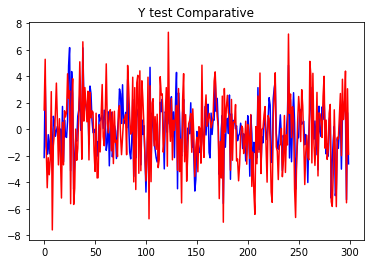

In [10]:
q = myModel.q_dist
Y_pred_tst = myModel.X[1]['mean'][Y_tr.shape[0]:,:]
plt.figure()
plt.plot(Y_pred_tst[:,0],'b')
plt.plot(Y_tst[:,0],'r')
plt.title('Y test Comparative')
plt.show()